In [1]:
# from mrcnn.config import Config
# from mrcnn import model as modellib
# from mrcnn import visualize
# import mrcnn
# from mrcnn.utils import Dataset
# from mrcnn.model import MaskRCNN
# import numpy as np
# from numpy import zeros
# from numpy import asarray
# import colorsys
# import argparse
# import imutils
# import random
# import cv2
# import os
# import time
# from matplotlib import pyplot
# from matplotlib.patches import Rectangle
# from keras.models import load_model
# %matplotlib inline
# from os import listdir
# from xml.etree import ElementTree


import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

%matplotlib inline

/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages

In [2]:
# Run one of the code blocks

# Shapes toy dataset

# import shapes
# config = shapes.ShapesConfig()

# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = "/home/cai/Desktop/simulation_synthetic_augmentation"  # TODO: enter value here

In [ ]:
# from PIL import Image

# png_images = os.listdir(COCO_DIR + '/train2014/')
# for png_image in png_images:
    
#     try:
#         png = Image.open(COCO_DIR + '/train2014/' + str(png_image)[:-4] + '.png')
#         png.save(COCO_DIR + '/train2014/' + str(png_image)[:-4] + '.jpg')
#         os.remove(COCO_DIR + '/train2014/' + png_image)
        
#     except:
#         continue
        

# png_images = os.listdir(COCO_DIR + '/val2014/')
# for png_image in png_images:
    
#     try:
#         png = Image.open(COCO_DIR + '/val2014/' + str(png_image)[:-4] + '.png')
#         png.save(COCO_DIR + '/val2014/' + str(png_image)[:-4] + '.jpg')
#         os.remove(COCO_DIR + '/val2014/' + png_image)
        
#     except:
#         continue

In [3]:
# Load dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "coco":
    dataset_train = coco.CocoDataset()
    dataset_train.load_coco(COCO_DIR, "train")
    dataset_val = coco.CocoDataset()
    dataset_val.load_coco(COCO_DIR, "val")

# Must call before using the dataset
dataset_train.prepare()
dataset_val.prepare()
print("Image Count: {}".format(len(dataset_train.image_ids)))
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

loading annotations into memory...
Done (t=2.44s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
Image Count: 4000
Class Count: 2
  0. BG                                                
  1. stone                                             
Image Count: 1000
Class Count: 2
  0. BG                                                
  1. stone                                             


## Display Samples

Load and display images and masks.

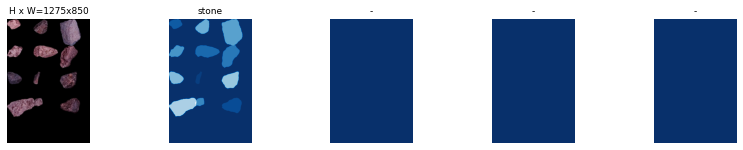

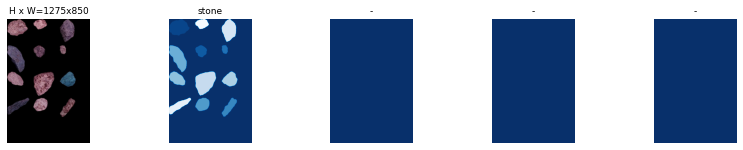

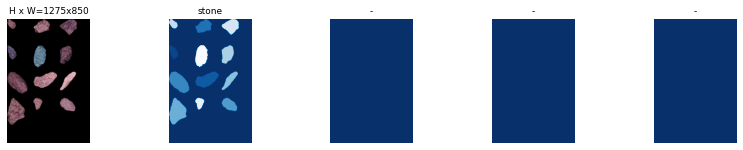

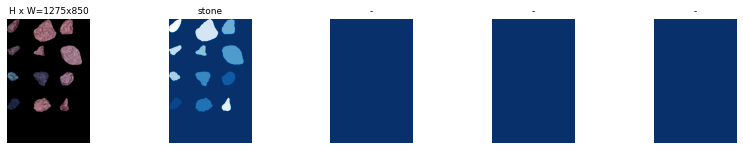

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updates masks rather than computing bounding box transformation for each type of image transformation.

image_id  3337 http://cocodataset.org/#explore?id=3337
image                    shape: (1275, 850, 3)        min:    0.00000  max:  255.00000  uint8
mask                     shape: (1275, 850, 12)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (12,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (12, 4)               min:    0.00000  max: 1049.00000  int32


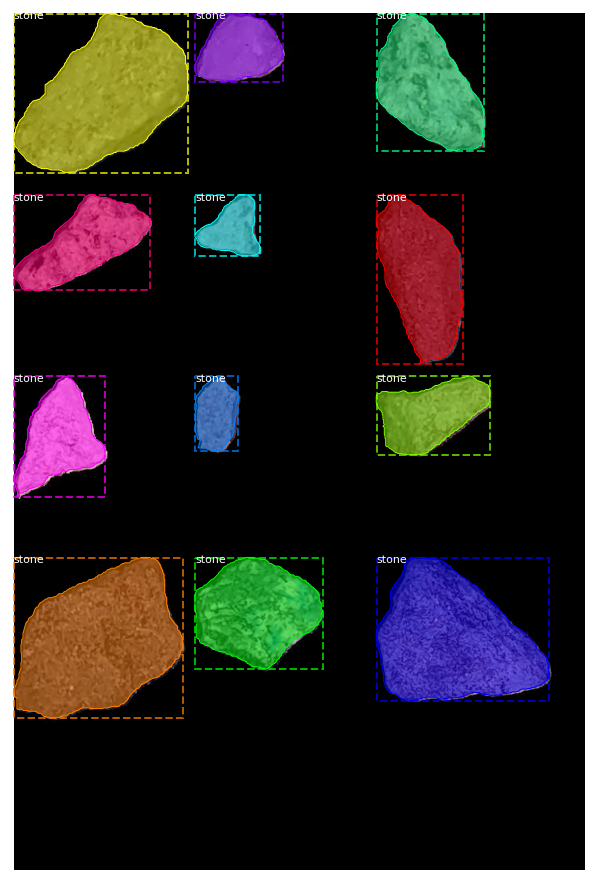

In [5]:
import mrcnn
import logging

# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = mrcnn.utils.extract_bboxes(mask)
# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset_train.class_names)

## Resize Images

To support multiple images per batch, images are resized to one size (1024x1024). Aspect ratio is preserved, though. If an image is not square, then zero padding is added at the top/bottom or right/left.

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [6]:
ROOT_DIR = "/home/cai/Desktop/simulation_synthetic_augmentation/Mask_RCNN" 
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [8]:

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/cai/Desktop/simulation_synthetic_augmentation/Mask_RCNN/logs/coco20201212T1620/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_

Instructions for updating:
Use tf.cast instead.


/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100
1000/1000 [==============================] - 1357s 1s/step - loss: 0.1489 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0137 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0207 - mrcnn_mask_loss: 0.0965 - val_loss: 0.0708 - val_rpn_class_loss: 2.8217e-04 - val_rpn_bbox_loss: 0.0051 - val_mrcnn_class_loss: 0.0049 - val_mrcnn_bbox_loss: 0.0056 - val_mrcnn_mask_loss: 0.0549
Epoch 2/100
1000/1000 [==============================] - 1143s 1s/step - loss: 0.0660 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0052 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0502 - val_loss: 0.0574 - val_rpn_class_loss: 2.0897e-04 - val_rpn_bbox_loss: 0.0037 - val_mrcnn_class_loss: 0.0035 - val_mrcnn_bbox_loss: 0.0036 - val_mrcnn_mask_loss: 0.0465
Epoch 3/100
1000/1000 [==============================] - 1138s 1s/step - loss: 0.0573 - rpn_class_loss: 5.2076e-04 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.0459 - val_loss: 

1000/1000 [==============================] - 1126s 1s/step - loss: 0.0373 - rpn_class_loss: 7.1178e-05 - rpn_bbox_loss: 0.0011 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0333 - val_loss: 0.0439 - val_rpn_class_loss: 9.0135e-04 - val_rpn_bbox_loss: 0.0043 - val_mrcnn_class_loss: 0.0019 - val_mrcnn_bbox_loss: 0.0017 - val_mrcnn_mask_loss: 0.0351
Epoch 23/100
1000/1000 [==============================] - 1115s 1s/step - loss: 0.0376 - rpn_class_loss: 7.4624e-05 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0332 - val_loss: 0.0421 - val_rpn_class_loss: 8.6588e-04 - val_rpn_bbox_loss: 0.0038 - val_mrcnn_class_loss: 0.0016 - val_mrcnn_bbox_loss: 0.0011 - val_mrcnn_mask_loss: 0.0347
Epoch 24/100
1000/1000 [==============================] - 1117s 1s/step - loss: 0.0370 - rpn_class_loss: 5.5432e-05 - rpn_bbox_loss: 0.0012 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 9.6416e-04 - mrcnn_mask_loss: 0.0330 - val_loss

Epoch 43/100
1000/1000 [==============================] - 1116s 1s/step - loss: 0.0334 - rpn_class_loss: 4.4886e-05 - rpn_bbox_loss: 8.0983e-04 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 6.7288e-04 - mrcnn_mask_loss: 0.0302 - val_loss: 0.0377 - val_rpn_class_loss: 5.2563e-05 - val_rpn_bbox_loss: 0.0011 - val_mrcnn_class_loss: 0.0014 - val_mrcnn_bbox_loss: 0.0011 - val_mrcnn_mask_loss: 0.0339
Epoch 44/100
1000/1000 [==============================] - 1121s 1s/step - loss: 0.0332 - rpn_class_loss: 4.1736e-05 - rpn_bbox_loss: 8.4000e-04 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 7.1379e-04 - mrcnn_mask_loss: 0.0302 - val_loss: 0.0486 - val_rpn_class_loss: 0.0011 - val_rpn_bbox_loss: 0.0043 - val_mrcnn_class_loss: 0.0052 - val_mrcnn_bbox_loss: 0.0033 - val_mrcnn_mask_loss: 0.0348
Epoch 45/100
1000/1000 [==============================] - 1123s 1s/step - loss: 0.0332 - rpn_class_loss: 4.4602e-05 - rpn_bbox_loss: 7.9104e-04 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 6.9766e-04 - mrcnn

Process Process-64:
Process Process-65:
Process Process-32:
Process Process-80:
Traceback (most recent call last):
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/utils/data_utils.py", line 655, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self

  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
  

  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwarg

  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "<string>", line 2, in put
  File "<string>", line 2, in put
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kind, result = conn.recv()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/managers.py", line 757, in _callmethod
    kin

  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
Process Process-14:
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/cai/anaconda3/envs/MRCNN/l

  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
KeyboardInterrupt
  File "<string>", line 2, in put
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/utils/data_utils.py", line 655, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/utils/data_utils.py", line 655, in _data_generator_task
    self.queue.put((True

KeyboardInterrupt: 

## Detection

In [9]:
class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
/home/cai/Desktop/simulation_synthetic_augmentation/Mask_RCNN/logs
Loading weights from  /home/cai/Desktop/simulation_synthetic_augmentation/Mask_RCNN/logs/coco20201212T1620/mask_rcnn_coco_0061.h5
Re-starting from epoch 61


In [10]:
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [11]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  217.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1275.00000  float64
gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (12, 4)               min:    0.00000  max:  875.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000  bool


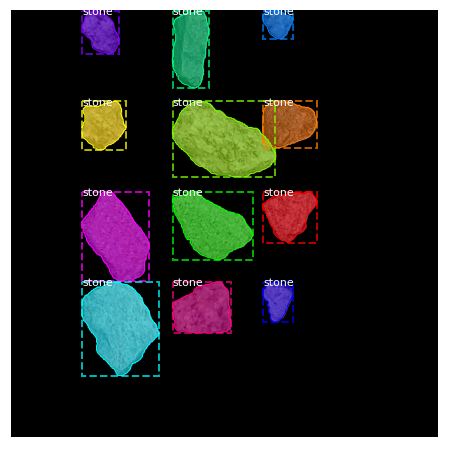

In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))



Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  217.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:   93.30000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


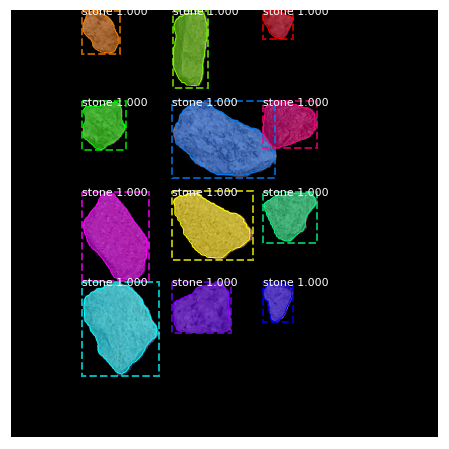

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
import skimage


class_names = ['stone']

# Load a random image from the images folder
IMAGE_DIR = "/cai_hdd/Sampyo_backup/crop_dataset_v6F/big/0"

file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread("/cai_hdd/Sampyo_backup/crop_dataset_v6F/big/99/\
G_99_3_up_c_1.1_0.0_nan_6.87515149416531_100.0_100.0_82.78160601128847_60.190796080196684_26.437896049032172_2.3806225977353823_0.8847259254129325_1_4.jpg")

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           ['BG', 'stone'], r['scores'])

In [ ]:
print(config.NAME)

In [ ]:
import coco
# Load dataset
if config.NAME == 'shapes':
    dataset = shapes.ShapesDataset()
    dataset.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
elif config.NAME == "MaskRCNN_config":
    dataset = coco.CocoDataset()
    dataset.load_coco(dataset_dir, "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

In [ ]:
images_dir = dataset_dir + 'image_MRCNN'
for filename in listdir(images_dir):
    # extract image id
    image_name = filename.split("_")
    image_id = (image_name[4])
    annotations_dir = dataset_dir + 'annotation_MRCNN/'
    ann_path = annotations_dir + "_groundtruth_(1)_images_stone_1.png_" + str(image_id[:-4])
    print(ann_path)

In [ ]:
class StoneDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "stone")
        
        # define data locations for images and annotations
        images_dir = dataset_dir + 'image_MRCNN/'
        annotations_dir = dataset_dir + 'annotation_MRCNN/'
        
        # Iterate through all files in the folder to 
        #add class, images and annotaions
        for filename in listdir(images_dir):
            
            # extract image id
            image_name = filename.split("_")
            image_id = (image_name[4])
#             # skip bad images
#             if image_id in ['00090']:
#                 continue
#             # skip all images after 150 if we are building the train set
#             if is_train and int(image_id) >= 150:
#                 continue
#             # skip all images before 150 if we are building the test/val set
#             if not is_train and int(image_id) < 150:
#                 continue
            
            # setting image file
            img_path = images_dir + filename
            
            # setting annotations file
            ann_path = annotations_dir + "_groundtruth_(1)_images_stone_1.png_" + str(image_id[:-4]) + '.json'
            
            # adding images and annotations to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
# extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
# load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')
# load an image reference
     #"""Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']

In [ ]:
# prepare train set
train_set = StoneDataset()
train_set.load_dataset(dataset_dir, is_train=True)
train_set.prepare()

print("Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

In [ ]:

# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 1)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, train_set.class_names)